In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

In [ ]:
cars_df = pd.read_csv("../data/cars/cars_dataset.csv", sep = "\t", encoding='utf-8')

# Chuyển đổi dữ liệu từ dữ liệu thô

In [ ]:
num_cols = ['price', 'length', 'height', 'width', 'weight', 'weightTotal', 'emissionsCO2', 'numberOfAxles',
            'numberOfDoors', 'numberOfForwardGears', 'seatingCapacity', 'cargoVolume', 'roofLoad', 
            'accelerationTime', 'fuelCapacity', 'fuelConsumption', 'speed', 'payload', 'trailerWeight', 
            'vEengineDisplacement', 'vEenginePower', 'torque']

In [ ]:
cat_cols = []
for col in cars_df.columns:
    if not (col in num_cols):
        cat_cols.append(col)

In [ ]:
print(len(num_cols), len(cat_cols))
print(num_cols, '\n', cat_cols)

### Xử lý các cột dữ liệu số

In [ ]:
# copy ra df để xư lý
df = cars_df.copy()

In [ ]:
# fucntion convert cac thuoc tinh khac
def cvtFloat(x):
    if type(x) == str:
        temp = x.replace(',', '.').split()[0]
    else:
        temp = x
    val = None
    try:
        val = float(temp)
    except ValueError:
        return val
    return val

In [ ]:
for el in num_cols:
    if el != 'cargoVolume':
        print(el)
        df[el] = df[el].apply(cvtFloat)

In [ ]:
# Hàm xử lý riêng cho cargoVolume
def cvtFloat_cargoVolume(x):
    temp = x.split()[0]
    temp = temp.replace('-', ' ')
    temp = temp.split()
    if len(temp) > 0:
        temp = temp[-1]
    else:
        temp = x
    val = None
    try:
        val = float(temp)
    except ValueError:
        return val
    return val

In [ ]:
df['cargoVolume'] = df['cargoVolume'].apply(cvtFloat_cargoVolume)

In [ ]:
df[num_cols].info()

### Xử lý các cột dữ liệu categorize

In [ ]:
for cat in cat_cols[:]:
    print(cat, len(cars_df[cat].unique()))

* Có thể loại bỏ cột vehicleTransmission vì chỉ có 1 giá trị, không có ý nghĩa trong việc học.
* Cột fuelType và vEfuelType là giống nhau (do quá trình crawl nhóm không để ý), có thể drop cột fuelType.
* Các cột url, name, model có nhiều ý nghĩa, nên có thể loại bỏ.
* brand có thể xét vì có tới 89 giá trị (có khả năng sẽ có ý nghĩa với các brand có giá trị cao), modelDate cần xem xét.

**=> Số cột còn lại là: eLabel (9), bodyType (11), driveWheelConfiguration (6), vEengineType (4), vEfuelType (11).**

In [ ]:
# chuẩn hóa cột modelDate
def norm_modelDate(x):
    if (x == 0):
        return None
    else:
        return str(x)
df['modelDate'] = df['modelDate'].apply(norm_modelDate)
df['modelDate'].unique()

In [ ]:
df['driveWheelConfiguration'].unique()

In [ ]:
df['bodyType'].unique()

In [ ]:
df['eLabel'].unique()

In [ ]:
df['vEengineType'].unique()

In [ ]:
df['vEfuelType'].unique()

* Cột driveWheelConfiguration không có giá trị lỗi ('N.A.', '-', ...)
* Các cột bodyType, vEengineType, vEfuelType có chứa nan (đã được xử lý).
* Cột eLabel có chứa các giá trị lỗi, cần được chuẩn hóa. Sau khi chuẩn hóa, dòng thiếu dữ liệu quá nhiều nên cần loại bỏ khi qua bước xử lý.

In [ ]:
def norm_eLabel(x):
    if (x == 'N.A.' or x == '-'):
        return None
    else:
        return x

In [ ]:
df['eLabel'] = df['eLabel'].apply(norm_eLabel)

In [ ]:
df[cat_cols].info()

### Lưu ra file để tiện xử lý

In [ ]:
# df.to_csv("cars_preprocessed_undrop.csv", sep = "\t", index=False, encoding='utf-8')

# Tiền xử lý dữ liệu và huấn luyện

In [19]:
df_ori = pd.read_csv("../data/cars/train_data.csv", sep = "\t", encoding='utf-8')

In [20]:
df = df_ori.copy()
draw_df = df_ori.copy()

In [21]:
num_cols = ['length','height','width','weight','emissionsCO2','numberOfAxles',
            'numberOfDoors','numberOfForwardGears','seatingCapacity','cargoVolume','roofLoad',
            'accelerationTime','fuelCapacity','fuelConsumption','speed',
            'payload','trailerWeight','vEengineDisplacement','vEenginePower','torque']
for col in num_cols:
    draw_df[col] = draw_df[col].apply(lambda x: draw_df[col].mean() if str(x) == 'nan' else x)

/home/hawliet/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


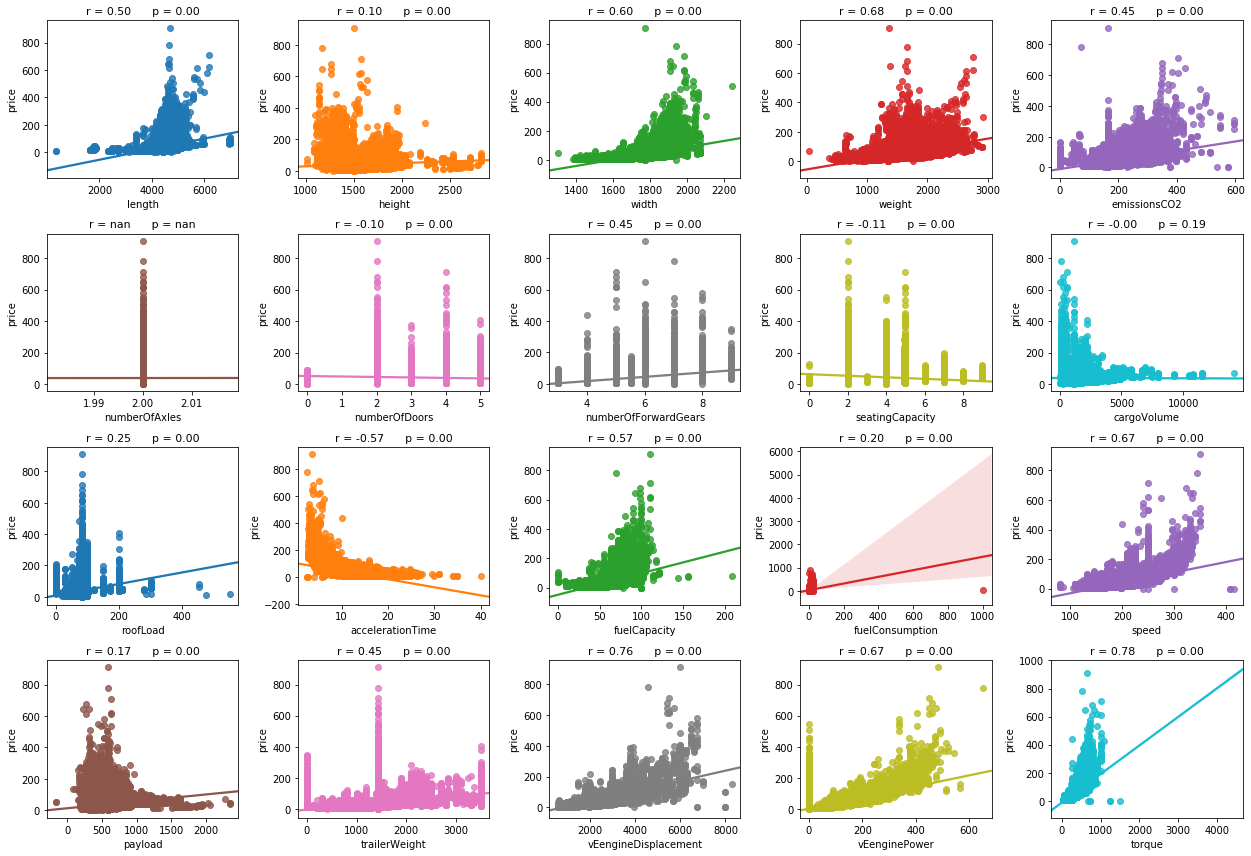

In [26]:
nr_rows = 4
nr_cols = 5

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(num_cols):
            sns.regplot(draw_df[num_cols[i]], draw_df['price'], ax = axs[r][c])
            stp = stats.pearsonr(draw_df[num_cols[i]], draw_df['price'])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

In [12]:
y = df['price']
X = df.drop(['price'], axis = 1)

In [5]:
# origin copy
X_ori = X.copy()
y_ori = y.copy()

In [6]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
len(train_X), len(val_X)

(60472, 15118)

## Tạo pipeline và build model

### Functions

#### Multilabel Encoding

In [8]:
def f(x, l):
    if type(x) is list:
        l.update(x)
class MultilabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name
        self.type_list = set()
    def fit(self, X_df, y=None):
        types_sr = X_df[self.col_name].str.replace('[/+]', ' ').str.split()
        types_sr.apply(f, args=(self.type_list,))
        self.type_list = list(self.type_list)
        return self
    def transform(self, X_df, y=None):
        transformed_df = X_df.copy()
        for i in range(len(self.type_list)):
            transformed_df[self.col_name + '_' + self.type_list[i]] = transformed_df[self.col_name].apply(lambda x: 1 if ((type(x) is str) and (self.type_list[i] in x)) else 0)
        transformed_df.drop(self.col_name, axis=1, inplace=True)
        return transformed_df

#### col add and drop

In [8]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_brands = 10):
        # TODO
        self.num_top_brands = num_top_brands
        self.dropped_cols = ['url', 'name', 'model', 'weightTotal', 'fuelType', 'vehicleTransmission', 'modelDate']
    def fit(self, X_df, y=None):
        brand_col = X_df.brand.str.extract(r'([a-zA-z]+)', expand=False)
        self.brand_counts_ = brand_col.value_counts()
        brands = list(self.brand_counts_.index)
        self.top_brands_ = brands[:max(1, min(self.num_top_brands, len(brands)))]
        return self
    def transform(self, X_df, y=None):
        df = X_df.copy()
        brand_col = df.brand.str.extract("([a-zA-z]+)", expand=False)
        brand_col[~brand_col.isin(self.top_brands_)] = 'Others'
        df["brand"] = brand_col
        df.drop(self.dropped_cols, axis=1, inplace=True)
        return df

In [9]:
cat_multi = ['vEfuelType', 'driveWheelConfiguration']
cat_single = ['brand', 'eLabel', 'bodyType', 'vEengineType']

In [10]:
col_adderdropper = ColAdderDropper()

In [13]:
num_cols = []
for col in X.columns:
    if (not col in cat_single) and (not col in cat_multi) and (not col in col_adderdropper.dropped_cols):
        num_cols.append(col)

In [13]:
len(num_cols), len(cat_single), len(cat_multi)

(20, 4, 2)

#### Hàm train và validate model

In [15]:
def train_and_val(full_pipeline, train_X, train_y, val_X, val_y):
    full_pipeline.fit(train_X, train_y);
    #print("n_brands:", len(col_adderdropper.top_brands_))
    pred_y = full_pipeline.predict(val_X)
    train_score = full_pipeline.score(train_X, train_y)
    val_score = full_pipeline.score(val_X, val_y)
    print(train_score, val_score)
    print("MSE =", np.round(np.mean((pred_y - val_y) ** 2), 3))
    print("MAE =", np.round(np.mean(np.abs(pred_y - val_y)), 3))
    return train_score, val_score

### các pipeline cần thiết cho pipeline cho preprocessing

In [ ]:
imp_mean = SimpleImputer(strategy='mean') 
imp_mode = SimpleImputer(strategy='most_frequent')

encoding = OneHotEncoder(handle_unknown='ignore', sparse=False)
vEfuelType_encoder = MultilabelEncoding('vEfuelType')
driveWheelConfig_encoder = MultilabelEncoding('driveWheelConfiguration')

categorical_transformer = make_pipeline(imp_mode, encoding)

colTransform = ColumnTransformer(transformers=[('numerical', imp_mean, num_cols),\
                                               ('categorical', categorical_transformer, cat_single),
                                               ('vEfuelType', vEfuelType_encoder, ['vEfuelType']),
                                               ('driveWheelConfig', driveWheelConfig_encoder, ['driveWheelConfiguration'])])

colNormalize = StandardScaler()

#preprocessing = make_pipeline(col_adderdropper, colTransform, colNormalize)

### Full pipeline với MLPRegressor

In [46]:
mlpregressor = MLPRegressor(hidden_layer_sizes=(512, 512, ), solver='adam', learning_rate='adaptive'\
                            ,random_state=0, max_iter=500, early_stopping=True, verbose=1)

# preprocessing.set_params(coladderdropper__num_top_brands = 100)

full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, mlpregressor)

full_pipeline.set_params(coladderdropper__num_top_brands = 100)

train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

Iteration 1, loss = 118.21336992
Validation score: 0.918466
Iteration 2, loss = 51.59492660
Validation score: 0.927055
Iteration 3, loss = 41.17943512
Validation score: 0.917445
Iteration 4, loss = 40.57601921
Validation score: 0.943541
Iteration 5, loss = 38.07106105
Validation score: 0.931364
Iteration 6, loss = 36.02121967
Validation score: 0.942704
Iteration 7, loss = 32.45201083
Validation score: 0.950768
Iteration 8, loss = 30.50328812
Validation score: 0.948153
Iteration 9, loss = 30.07735884
Validation score: 0.895205
Iteration 10, loss = 29.28604368
Validation score: 0.957604
Iteration 11, loss = 26.19919631
Validation score: 0.947231
Iteration 12, loss = 25.17911201
Validation score: 0.957905
Iteration 13, loss = 22.67125845
Validation score: 0.957836
Iteration 14, loss = 21.64723883
Validation score: 0.933712
Iteration 15, loss = 25.12423811
Validation score: 0.961494
Iteration 16, loss = 19.95843145
Validation score: 0.962914
Iteration 17, loss = 17.98747073
Validation scor

(0.9771158431945284, 0.749004253783355)

#### model (512, 256, 512)

In [49]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(512, 256, 512, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.981888215514595 0.7352570716057742
MSE = 239.862
MAE = 2.776


(0.981888215514595, 0.7352570716057742)

#### model (256, 256, 256)

In [51]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 256, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9642044573025929 0.8159559148084718
MSE = 166.747
MAE = 3.092


(0.9642044573025929, 0.8159559148084718)

#### model (256, 512, 256)

In [53]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9753737214003044 0.8785176367245763
MSE = 110.065
MAE = 2.886


(0.9753737214003044, 0.8785176367245763)

#### model (256, 512, 512, 256)

In [57]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9469180582378245 0.8917373042694016
MSE = 98.088
MAE = 3.41


(0.9469180582378245, 0.8917373042694016)

#### model (256, 512, 512, 256, 128)

In [58]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 256, 128, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.968874482026066 0.8829205161438752
MSE = 106.076
MAE = 3.27


(0.968874482026066, 0.8829205161438752)

#### model (256, 512, 512, 512, 256)

In [62]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 512, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9739361561697789 0.8771331410776515
MSE = 111.32
MAE = 2.858


(0.9739361561697789, 0.8771331410776515)

In [16]:
# mlpregressor = MLPRegressor(hidden_layer_sizes=(16, 32, 64, 64, 32, 16, ), solver='adam', learning_rate='adaptive'\
#                             ,random_state=0, max_iter=500, early_stopping=True, verbose=0)
# full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, mlpregressor)

#### Chọn model (256, 512, 512, 256) đạt val cao nhất ở trên

In [63]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 256, ))
nn_train_scores, nn_val_scores = [], []
best_n_brands, nn_best_val_score = 10, -float('inf')
for n_brands in range(5, 95, 5):
    print('...')
    full_pipeline.set_params(coladderdropper__num_top_brands=n_brands)
    train_score, val_score = train_and_val(full_pipeline, train_X, train_y, val_X, val_y)
    if (nn_best_val_score < val_score):
        nn_best_val_score = val_score
        best_n_brands = n_brands
    nn_train_scores.append(train_score)
    nn_val_scores.append(val_score)
    print()
'Finish!'

...
0.9791494784842625 0.43344014041802026
MSE = 513.313
MAE = 2.988

...
0.9731883254778363 0.8046131333876603
MSE = 177.024
MAE = 2.988

...
0.9829765185771713 0.8876575305881531
MSE = 101.784
MAE = 2.753

...
0.976672852667346 0.6743385800656309
MSE = 295.055
MAE = 2.917

...
0.9832243972846563 0.5834422253188625
MSE = 377.409
MAE = 2.751

...
0.984801314293368 0.690991486883802
MSE = 279.967
MAE = 2.73

...
0.979575290423483 0.4079606426540987
MSE = 536.398
MAE = 2.939

...
0.975239152304768 0.5262786659719526
MSE = 429.2
MAE = 3.054

...
0.9705926095608685 0.44741376702971125
MSE = 500.653
MAE = 3.09

...
0.9782401532901732 0.8268903813601218
MSE = 156.84
MAE = 2.881

...
0.9793347470305559 0.6632491395877306
MSE = 305.102
MAE = 2.697

...
0.9831734794316592 0.6513520997837019
MSE = 315.881
MAE = 2.734

...
0.9699991800617898 0.7943542003140663
MSE = 186.319
MAE = 3.063

...
0.9702111745202495 0.8246429957225752
MSE = 158.877
MAE = 3.047

...
0.9624448018585803 0.8257609143790342


'Finish!'

In [64]:
best_n_brands, nn_best_val_score

(80, 0.9084258826395483)

#### train model với số lượng brands tốt nhất tìm được

In [73]:
full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, mlpregressor)
full_pipeline.set_params(coladderdropper__num_top_brands=best_n_brands, mlpregressor__verbose=1)
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

Iteration 1, loss = 110.52255792
Validation score: 0.912572
Iteration 2, loss = 49.38537994
Validation score: 0.929341
Iteration 3, loss = 42.36607669
Validation score: 0.907784
Iteration 4, loss = 37.45430971
Validation score: 0.908483
Iteration 5, loss = 34.44423371
Validation score: 0.932812
Iteration 6, loss = 31.64429352
Validation score: 0.946523
Iteration 7, loss = 32.71341469
Validation score: 0.953914
Iteration 8, loss = 30.87134850
Validation score: 0.944977
Iteration 9, loss = 28.41512787
Validation score: 0.930272
Iteration 10, loss = 24.64215567
Validation score: 0.941124
Iteration 11, loss = 20.85456710
Validation score: 0.949821
Iteration 12, loss = 23.11471746
Validation score: 0.949044
Iteration 13, loss = 22.16119754
Validation score: 0.958072
Iteration 14, loss = 20.22076275
Validation score: 0.961556
Iteration 15, loss = 17.69097487
Validation score: 0.954782
Iteration 16, loss = 16.27896902
Validation score: 0.954013
Iteration 17, loss = 14.89289736
Validation scor

(0.9713321102687602, 0.9084258826395483)

#### save model

In [74]:
# joblib.dump(full_pipeline, 'nn_80.pkl')

['nn_80.pkl']

### full pipeline với RandomForestRegressor

In [31]:
rfregressor = RandomForestRegressor(n_estimators=1, random_state=0, verbose=1)
full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, rfregressor)
full_pipeline.set_params(coladderdropper__num_top_brands = 90);

In [37]:
full_pipeline.set_params(randomforestregressor__verbose = 0)
rf_train_scores, rf_val_scores = [], []
best_n_estimators, best_val_score = 1, -float('inf')
n_estimators = 1
while (n_estimators < 1024):
    print('n_estimators: ',n_estimators)
    full_pipeline.set_params(randomforestregressor__n_estimators = n_estimators)
    train_score, val_score = train_and_val(full_pipeline, train_X, train_y, val_X, val_y)
    rf_train_scores.append(train_score)
    rf_val_scores.append(val_score)
    if best_val_score < val_score:
        best_val_score, best_n_estimators = val_score, n_estimators
    n_estimators *= 2
    print()

n_estimators:  1
0.9718247797364523 0.9478718245603407
MSE = 47.229
MAE = 3.163

n_estimators:  2
0.9828131031479419 0.9606942242194864
MSE = 35.612
MAE = 2.875

n_estimators:  4
0.986878391887526 0.9665858439464541
MSE = 30.274
MAE = 2.673

n_estimators:  8
0.9884801786779545 0.9730351534046627
MSE = 24.431
MAE = 2.554

n_estimators:  16
0.9903936076513717 0.9762188046877665
MSE = 21.546
MAE = 2.502

n_estimators:  32
0.9913698175139225 0.9761451846033995
MSE = 21.613
MAE = 2.471

n_estimators:  64
0.9916120780081737 0.9762780659135604
MSE = 21.492
MAE = 2.455

n_estimators:  128
0.9919707938386294 0.9762435383099555
MSE = 21.524
MAE = 2.449

n_estimators:  256
0.9920670454581194 0.9765652539792711
MSE = 21.232
MAE = 2.444

n_estimators:  512
0.9920278565547928 0.9765225206626313
MSE = 21.271
MAE = 2.445



In [65]:
rfregressor = RandomForestRegressor(n_estimators=1024, random_state=0, verbose=1)
full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, rfregressor)
full_pipeline.set_params(coladderdropper__num_top_brands = 90)
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed: 30.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  6.6min finished


0.9921103998585453 0.9766075892992062
MSE = 21.194
MAE = 2.443


(0.9921103998585453, 0.9766075892992062)

In [71]:
# save model
# joblib.dump(full_pipeline, 'rf_1024.pkl')

['rf_1024.pkl']

# Testing

In [ ]:
#full_pipeline.set_params(mlpregressor__alpha=best_alpha)
pred_y = full_pipeline.predict(test_X)

In [ ]:
pred_y

In [ ]:
np.array(test_y)

In [ ]:
np.mean(np.abs(pred_y - test_y))

In [ ]:
np.mean(np.abs(pred_y - test_y))

In [ ]:
np.mean((pred_y - test_y) ** 2)

In [ ]:
np.mean((pred_y - test_y) ** 2)